In [1]:
# =================================
# General packages
# =================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from scipy.interpolate import interp1d

# =================================
# Load packages for ISiTGR and fkpt
# =================================
# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt
# ---- ISiTGR ----
import isitgr
from isitgr import model

# =================================
# Load packages for desilike
# =================================
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)

# Define common parameters

In [10]:
# ==========================
# Cosmology parameters
# ==========================
h      = 0.6736
ombh2  = 0.02237
omch2  = 0.1300
#omnuh2 = 0.0
omnuh2 = 0.000644
As     = 2.1e-9
ns     = 0.9649
N_eff  = 3.046
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)
# default omegam Omega_m: 0.3137721026737606

# ==========================
# Observation redshift
# ==========================
z_pk   = 0.3

# ==========================
# scale ranges
# ==========================
KMAX = 0.5
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# ==========================
# Nuisance parameters
# ==========================
b1 = 1.0 # 1.70
b2 = 0.0 # -0.45
bs2  = 0.0 # -4/7*(b1 - 1)
b3nl = 0.0 # 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 0.0, 0.0, 0.0, 0.0 # 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.0, 0.0, 1000.0 # 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# ==========================
# MG parameters
# ==========================
mu0=0.0

Omega_m: 0.3372306280713831


# Calculate isitgr+fkpt

Get ISiTGR part

In [18]:
# ---- ISiTGR params ----
pars = isitgr.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2, MG_parameterization="muSigma", mu0=mu0)
pars.InitPower.set_params(As=As, ns=ns)

# build a *local guarded* pad around z_pk so the central window always fits
z_pad = model.redshift_padding(z_pk)

# run once on the pad
pars.set_matter_power(redshifts=z_pad)#, kmax=CAMB_KMAX)
pars.NonLinear = model.NonLinear_none
results = isitgr.get_results(pars)

kh_new, z_new, pk_new = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=500, var1='delta_nonu', var2='delta_nonu')

# linear P(k) and f(k) at zeff=z_pk
PK, redshifts, ks = results.get_matter_power_interpolator(
    nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True,
    var1='delta_nonu', var2='delta_nonu'
)
pk_lin = PK.P(z_pk, ks)

ks_fk, fzk = results.get_growth_rate(z_pk)
fk_lin = fzk[0]                    # (Nk,)
assert np.allclose(ks_fk, ks)      # same k-grid

# cut to analysis k-range
mask   = ks <= KMAX
ks_cut = ks[mask]
pk_cut = pk_lin[mask]
fk_cut = fk_lin[mask]

# small-k average for f0 (for tables that want a single number)
smallk = ks_cut < 3e-3
f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

Note: redshifts have been re-sorted (earliest first)


In [19]:
fkpt_parameters = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    mu0=mu0,
    model="HDKI",
    mg_variant="mu_OmDE",
    rescale_PS=True,
    use_beyond_eds_kernels=False
)

# FKPT evaluation grid
base = dict(
    **fkpt_parameters,
    kmin=float(max(1e-3, ks_cut.min())),
    kmax=float(min(ks_cut.max(), KMAX)),
    Nk=int(min(ks_cut.size, 500)),
)
k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

# beyond-EdS kernels
#tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **base)
tables = pyfkpt.compute_multipoles(k=kh_new, pk=pk_new[3,:], **base)
k_MG, P0_MG, P2_MG, P4_MG = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=True, Omfid=0.3137721026737606, tables=tables)

In [20]:
k_eval[5]-k_eval[4], k_eval[2]-k_eval[1]
ks_cut[-1]

0.49838611483573914

Plotting

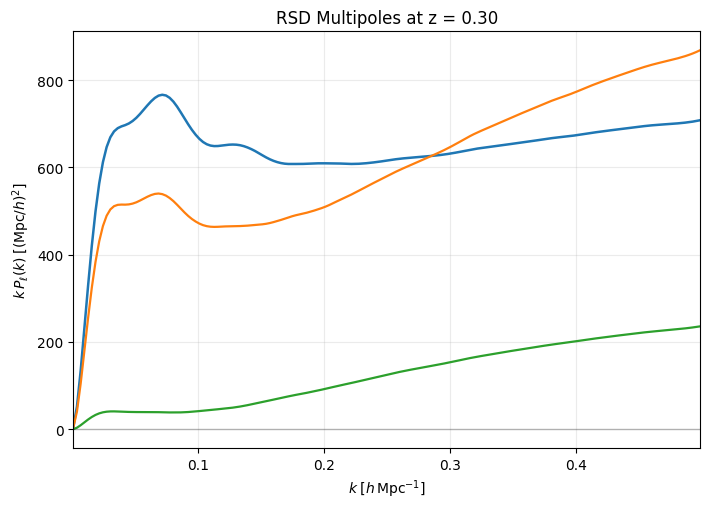

In [21]:
fig, ax = plt.subplots(figsize=(7.2, 5.2))

# plot: same style per scenario; label only once per scenario
ax.plot(k_MG, k_MG*P0_MG, linewidth=1.8, label='$P_0$')  # ℓ=0 (carries legend label)
ax.plot(k_MG, k_MG*P2_MG, linewidth=1.6, label='$P_2$')               # ℓ=2
ax.plot(k_MG, k_MG*P4_MG, linewidth=1.6, label='$P_4$')               # ℓ=4

ax.set_xlabel(r"$k\;[h\,\mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$k\,P_\ell(k)\;[(\mathrm{Mpc}/h)^2]$")
ax.set_title(f"RSD Multipoles at z = {z_pk:.2f}")

ax.set_xlim(base["kmin"], base["kmax"])
ax.axhline(0, color='k', alpha=0.25, lw=1.0)

# ax.set_xscale('log')  # optional
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Calculate using desilike calling isitgr+fkpt internally

Get desilike part

In [25]:
# ==========================
# Define cosmology object
# ==========================
cosmo_desilike = Cosmoprimo(engine='isitgr', MG_parameterization="muSigma", N_eff=N_eff, m_ncdm=[0.06])
cosmo_desilike.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]))  # add parameters
#cosmo_desilike.init.params.pop('m_ncdm')  # remove neutrino masses
cosmo_desilike.init.params['mu0'].update(value=mu0)  # compute cosmology

cosmo_params = {
    "h": h,
    "omega_b": ombh2,
    "omega_cdm": 0.12,
    "logA": np.log(1e10*As),
    "ns": ns,
}

for name, value in cosmo_params.items():
    if name in cosmo_desilike.params:
        cosmo_desilike.init.params[name].update(value=value)

# ==========================
# Define template
# ==========================
k=np.linspace(0.001,0.5,500)
from cosmoprimo.fiducial import DESI
template_desilike = DirectPowerSpectrumTemplate(z=z_pk, fiducial=DESI(), cosmo=cosmo_desilike)
theory_desilike =  fkptTracerPowerSpectrumMultipoles()
theory_desilike.init.update(template=template_desilike, prior_basis='standard', k=k, beyond_eds=False)

# ==========================
# Update theory
# ==========================
nuis_params = {
    "b1": b1,
    "b2": b2,
    "bs2": bs2,
    "b3nl": b3nl,
    "alpha0": alpha0,
    "alpha2": alpha2,
    "alpha4": alpha4,
    "ctilde": ctilde,
    "alpha0shot": alpha0shot,
    "alpha2shot": alpha2shot,
}

for name, value in nuis_params.items():
    if name in theory_desilike.init.params:
        theory_desilike.init.params[name].update(value=value)

# ==========================
# Calculate!
# ==========================
P0_desi, P2_desi, P4_desi = theory_desilike(omega_cdm=0.13)
k_desi = theory_desilike.k

/n/home12/cgarciaquintero/.conda/envs/cosmodesi/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


/n/home12/cgarciaquintero/MG/codes/fkpt/pyfkpt/rsd.py
{'b1': array(1.), 'b2': array(0.), 'bs2': array(0.), 'b3nl': array(0.), 'alpha0': array(0.), 'alpha2': array(0.), 'alpha4': array(0.), 'ctilde': array(0.), 'alpha0shot': array(0.), 'alpha2shot': array(0.), 'Om': 1.535282009073314, 'PshotP': 10000.0, 'model': 'HDKI', 'mg_variant': 'mu_OmDE', 'mu0': 0.0, 'h': 0.6736, 'z': array(0.3), 'nquadSteps': 300, 'chatty': 0, 'rescale_PS': False, 'use_beyond_eds_kernels': False}


In [26]:
k_desi[4]-k_desi[3], k_desi[2]-k_desi[1]

(0.001, 0.001)

# Plotting and comparing both!

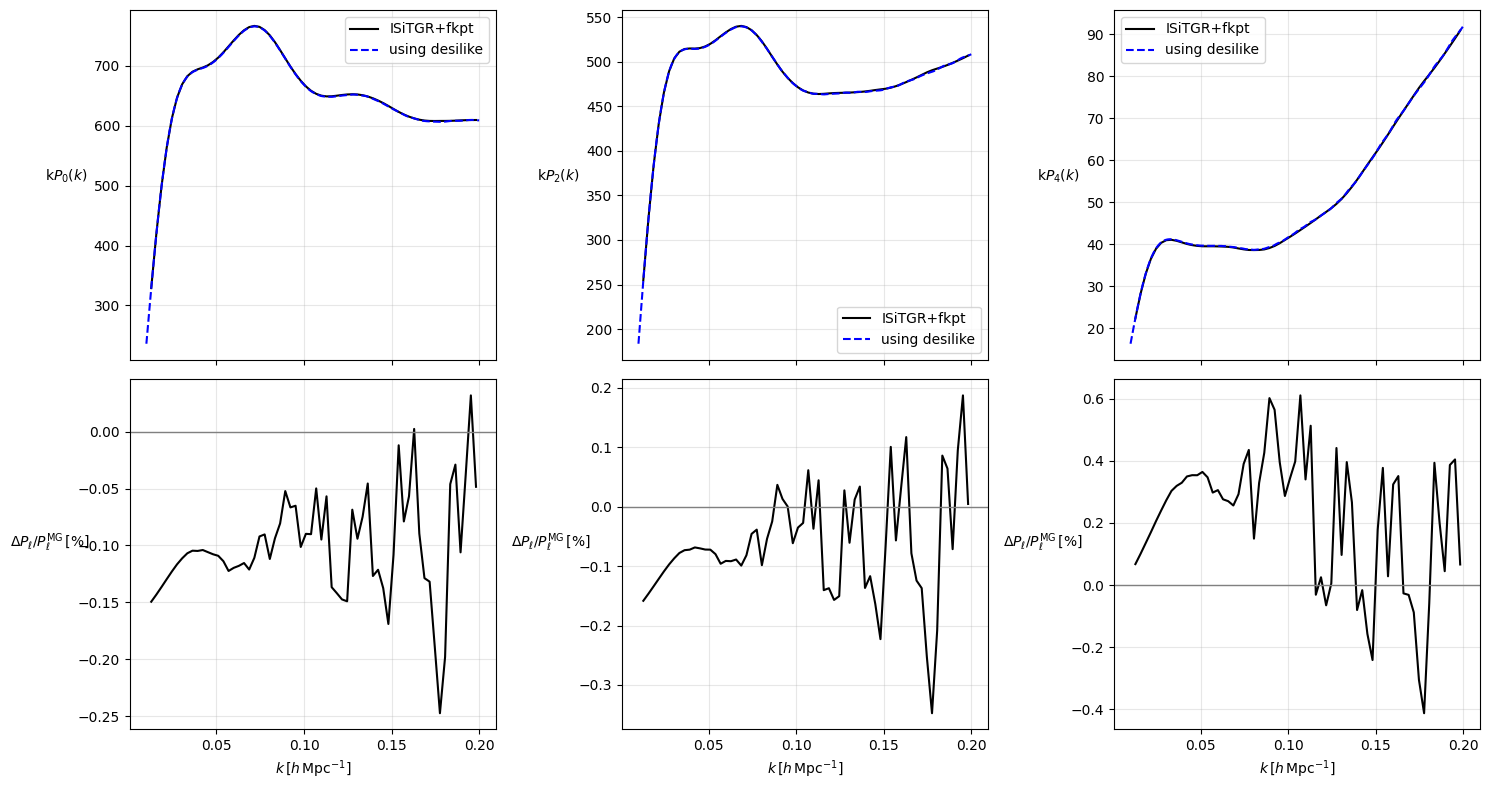

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ======================================================
# Plot configuration
# ======================================================
kmin_plot = 0.01
kmax_plot = 0.20

# ======================================================
# 1) Interpolate desilike results to get relative errors
# 2) Compare with ISiTGR+fkpt results (without desilike)
# ======================================================

# --- mask data within plotting range ---
mask_MG = (k_MG >= kmin_plot) & (k_MG <= kmax_plot)
mask_desi = (k_desi >= kmin_plot) & (k_desi <= kmax_plot)

k_MG_plot = k_MG[mask_MG]
k_desi_plot = k_desi[mask_desi]

P0_MG_plot = P0_MG[mask_MG]
P2_MG_plot = P2_MG[mask_MG]
P4_MG_plot = P4_MG[mask_MG]

P0_desi_plot = P0_desi[mask_desi]
P2_desi_plot = P2_desi[mask_desi]
P4_desi_plot = P4_desi[mask_desi]

# --- interpolation functions for DESI ---
fP0 = interp1d(k_desi_plot, P0_desi_plot, kind='cubic', fill_value="extrapolate")
fP2 = interp1d(k_desi_plot, P2_desi_plot, kind='cubic', fill_value="extrapolate")
fP4 = interp1d(k_desi_plot, P4_desi_plot, kind='cubic', fill_value="extrapolate")

# Interpolate DESI on MG k-grid
P0_desi_interp = fP0(k_MG_plot)
P2_desi_interp = fP2(k_MG_plot)
P4_desi_interp = fP4(k_MG_plot)

# --- compute relative error (%): (DESI - MG)/MG * 100 ---
err_P0 = (P0_desi_interp - P0_MG_plot) / P0_MG_plot * 100
err_P2 = (P2_desi_interp - P2_MG_plot) / P2_MG_plot * 100
err_P4 = (P4_desi_interp - P4_MG_plot) / P4_MG_plot * 100

# ======================================================
# Plotting
# ======================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')
labels = [r"k$P_0(k)$", r"k$P_2(k)$", r"k$P_4(k)$"]
MG = [P0_MG_plot, P2_MG_plot, P4_MG_plot]
DESI = [P0_desi_plot, P2_desi_plot, P4_desi_plot]
ERR = [err_P0, err_P2, err_P4]

for i in range(3):
    # top row: Pℓ comparison
    ax = axes[0, i]
    ax.plot(k_MG_plot, k_MG_plot * MG[i], color='black', label='ISiTGR+fkpt')
    ax.plot(k_desi_plot, k_desi_plot * DESI[i], color='blue', linestyle='--', label='using desilike')
    ax.set_ylabel(labels[i], rotation=0, labelpad=20)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # bottom row: relative error
    ax2 = axes[1, i]
    ax2.plot(k_MG_plot, ERR[i], color='black')
    ax2.axhline(0, color='gray', lw=1)
    ax2.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")
    ax2.set_ylabel(r"$\Delta P_\ell / P_\ell^\mathrm{MG}\,[\%]$", rotation=0, labelpad=20)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()